# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-09 13:12:34.805746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 13:12:34.805865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 13:12:34.953555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data exploration 

## Plotting example images

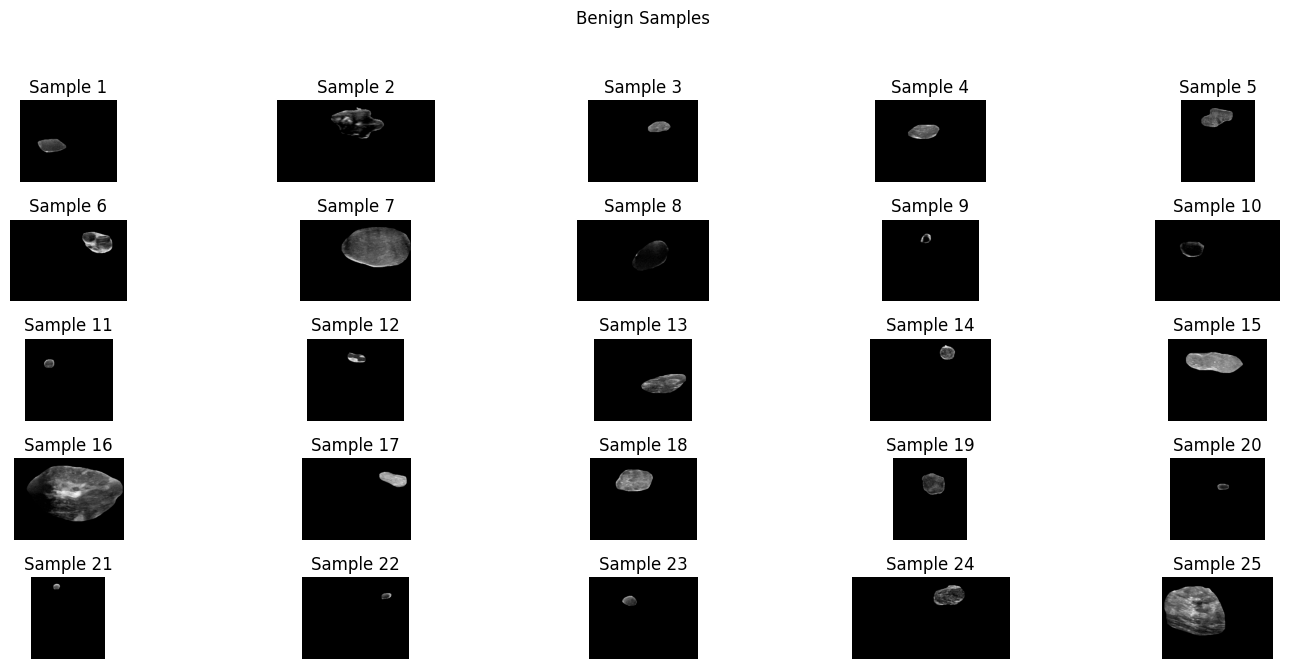

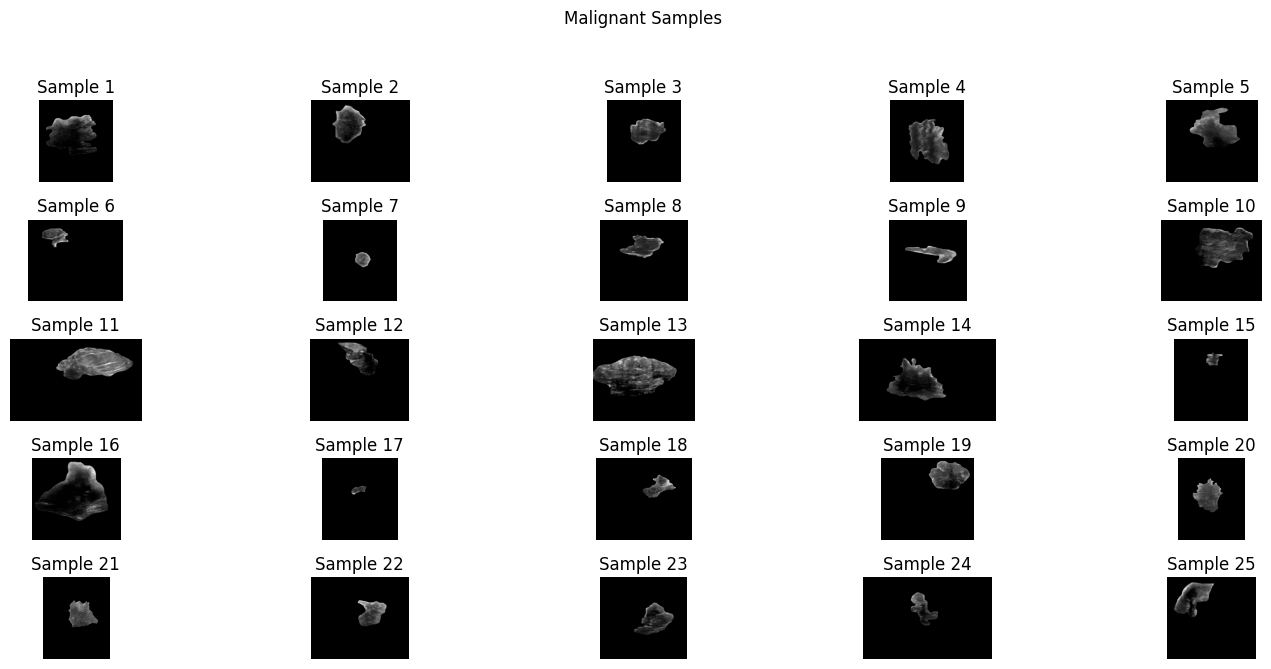

In [3]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'

plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [4]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant'] 
    data = [] 

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]
        
        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])
   
    df = pd.DataFrame(data)
    return df

training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(668, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1       case037.png         benign
2  benign (390).png         benign
3  benign (357).png         benign
4       case231.png         benign


## Is there a class imbalance? 

In [5]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       442
malignant    226
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [6]:
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'

# parameters
batch_size = 32
img_height = 224  
img_width = 224   

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Inspect Preprocessed Images?

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from kerastuner import HyperModel

class EfficientNetHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Load EfficientNetB0 as the base model
        base_model = EfficientNetB0(include_top=False, input_shape=self.input_shape, weights='imagenet')
        base_model.trainable = False  # prevent changes to its learned weights
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),  # better feature pooling
            layers.Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'
            ),
            layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
            layers.Dense(1, activation='sigmoid')  # binary classification
        ])
        
        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model

from kerastuner.tuners import RandomSearch

input_shape = (224, 224, 3)
hypermodel = EfficientNetHyperModel(input_shape)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # configurations to try
    executions_per_trial=1,  # times to train each configuration
    directory='my_tuner_dir',
    project_name='efficientnet_tuning'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
input_shape = (224, 224, 3) 
hypermodel = EfficientNetHyperModel(input_shape)

In [9]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # number of trials
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientNet_tuning'
)

tuner.search(dataset, validation_data=validation_dataset, epochs=10)

Trial 10 Complete [00h 01m 14s]
val_accuracy: 0.9172932505607605

Best val_accuracy So Far: 0.9172932505607605
Total elapsed time: 00h 12m 25s


In [10]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print('Best model summary:')
best_model.summary()
print('Best hyperparameters:', best_hyperparameters.values)

Best model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 288)            │       368,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418,788 (16.86 MB)

 Trainable params: 369,217 (1.41 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Best hyperparameters: {'units': 288, 'dropout': 0.30000000000000004, 'optimizer': 'adam'}


## My best model so far

### Building the model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_model():
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False 

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # global average pooling layer
        Dense(416, activation='relu'),  # dense layer with 416 units
        Dropout(0.2),  # dropout with rate 0.2
        Dense(1, activation='sigmoid')  # for binary classification
    ])

    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 

    return model

model = build_efficientnet_model()

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train model

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model
history = model.fit(
    dataset,  
    epochs=20,  # Number of epochs to train for
    validation_data=validation_dataset,  
    callbacks=callbacks  # Include callbacks for early stopping and saving the best model
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8119 - loss: 0.3941  
Epoch 1: val_accuracy improved from -inf to 0.87970, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8156 - loss: 0.3890 - val_accuracy: 0.8797 - val_loss: 0.3025
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9199 - loss: 0.2171
Epoch 2: val_accuracy improved from 0.87970 to 0.90226, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9201 - loss: 0.2171 - val_accuracy: 0.9023 - val_loss: 0.2940
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9255 - loss: 0.1769
Epoch 3: val_accuracy did not improve from 0.90226
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9251 - loss: 0.1785 - val_accuracy: 0.8947 - val_loss: 0.3168
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9223 - loss: 0.1839
Epoch 4: val_accuracy did not improve from 0.90226
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/s

In [13]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

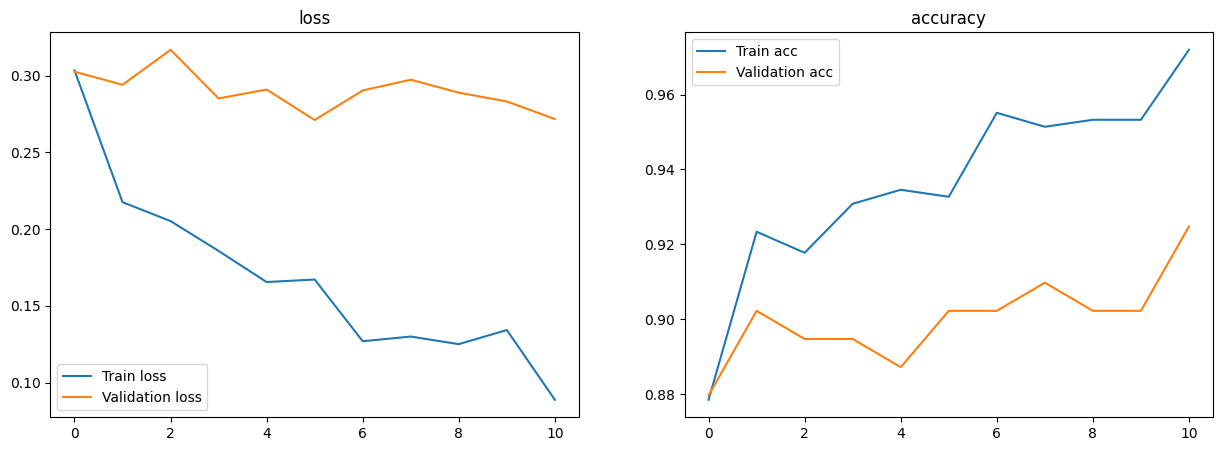

In [14]:
plot_history(history)

In [15]:
import warnings
warnings.filterwarnings('ignore') 

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    label_mode='binary',
    image_size=(224, 224), 
    color_mode='rgb', 
    batch_size=32)  

# evaluate model on test dataset 
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 100 files belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8951 - loss: 0.3560 
Test Loss: 0.33539775013923645
Test Accuracy: 0.9200000166893005
